## Chapter 01: Log-Linear Model


### 1. Introduction

Solomon-Wynne in 1953 conducted an experiment on Dogs. He wanted to understand, whether Dogs can learn from mistakes, so to speak. Specifically, They were interested in _avoidance-learning_. That is, when Dogs are given trauma-inducing shocks; Will they learn to avoid shocks in future?

We can state the objectives of the expeirment, according to our understanding, in more general terms as follows:

1. Can the Dogs learn?
2. Can they retain & recollect what they learnt?

The experimental setup, to drive the objectives, holds a dog in a closed compartment with steel flooring, open on one side with a small barrier for dog to jump over to the other side. A high-voltage electric shock is discharged into the steel floor intermittently to stimulate the dog. The dog is then left with an option to either get the shock for that trial or jump over the barrier to other side & save himself. Several dogs were recruited in the experiment.

The following picture is an illustration of the setup.
<br>
<br>
![dog_setup](./data/avoidance_learning.png)
<br>
<br>
More details of the experiment can be found [here](http://www.appstate.edu/~steelekm/classes/psy5300/Documents/Solomon&Wynne%201953.pdf).

<br>
<br>

In this chapter, we will analyze the experimental data using _Bayesian Analysis_, and the inference will be carried out in `Pyro`. The organization of the notebook is inspired from [Bayesian Workflow](http://www.stat.columbia.edu/~gelman/research/unpublished/Bayesian_Workflow_article.pdf) by Prof. Andrew Gelman et al. Another piece of work in that direction is from Betancourt et al [here](https://arxiv.org/abs/1904.12765). However, the current analysis is a WIP and far from perfect.


An almost always first step in Bayesian Analysis is to elicit a plausible generative model, that would have likely generated the observed data. In this case, consider the model suggesed/implemented in WinBUGs [Vol1](https://www.mrc-bsu.cam.ac.uk/wp-content/uploads/WinBUGS_Vol1.pdf).

We want to model the relationship between __avoidance-in-future__ and __past-traumatic-experiences__ . The following log-linear model is a starting point:
<br>
<br>
$\pi_j   =   A^{xj} B^{j-xj} $
<br>
<br>
where :
   * $\pi_j$ is the probability of a dog getting shocked at trial $j$
   * $x_j$ is number of successful avoidances of shock prior to trial $j$.
   * $j-x_j$ is number of shocks experienced prior to trial $j$.
   * A & B, both are unknown and treated as random variables.

However, the model is only partially complete. In a Bayesian setting, we need to elicit our prior beliefs about the unknowns. Consequently, we need to give priors to $A$ and $B$, which we do shortly. Before that, we need some boiler plate code, mostly `imports`. Note that, all the code (functions) are glued in the [base](https://github.com/mlsquare/p3/blob/p3_part_2_ch01/Part_II/Chapter_1/chapter01.py) class. If one is interested, they can always browse the code [repo](https://github.com/mlsquare/p3) to get better understanding.

In [1]:
import torch
import pyro
import pandas as pd
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import pyro.distributions as dist
import seaborn as sns
import plotly
import plotly.express as px
import plotly.figure_factory as ff
from chapter01 import base
import numpy as np

pyro.set_rng_seed(1)


plt.style.use('default')

%matplotlib inline
%load_ext autoreload

#### Data
<br>
<br>
The data contains experiments over 30 dogs, each dog is subjected to 25 trials.

The plot that follows highlights Dogs data in dictionary format, averaged over dog population for each trial.

write latex for summation of `averaged over dog population for each trial.`

In [2]:
dogs_data = base.load_data()
base.plot_original_y(np.mean(dogs_data["Y"], axis=0), ylabel='Probability of avoidance at trial j')

Its apparent from experimental data that more than half the dog population learns to avoid shocks in trials as few as 5, and also that the learning doesn't significantly rise with increased number of trials.

#### Preprocessing
<br>
<br>

Following transforms target label `Y` to obtain input data `x_avoidance`, `x_shocked` & `y` where:
* `x_avoidance` :  number of shock avoidances before current trial.
* `x_shocked` :  number of shocks before current trial.
* `y`: Status 'shocked or avoided' at current trial.

Here `pystan` format [data](https://github.com/stan-dev/example-models/blob/master/bugs_examples/vol1/dogs/dogs.data.R) (python dictionary) is passed to the function above, in order to preprocess it to tensor format required for pyro sampling.

In [3]:
x_avoidance, x_shocked, y = base.transform_data(**dogs_data)
print("x_avoidance: %s, x_shocked: %s, y: %s"%(x_avoidance.shape, x_shocked.shape, y.shape))
print("\nSample x_avoidance: %s \n\nSample x_shocked: %s"%(x_avoidance[1], x_shocked[1]))

base.plot_original_y(x_avoidance.numpy(), ylabel='Cumulative Avoidances')
base.plot_original_y(x_shocked.numpy(), ylabel='Cumulative Shocked Trials')

x_avoidance: torch.Size([30, 25]), x_shocked: torch.Size([30, 25]), y: torch.Size([30, 25])

Sample x_avoidance: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 2., 3.]) 

Sample x_shocked: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 20., 21., 21.])


The original data is not revealing much, looking at the cumulative avoidances and shocks, we see that some dogs never learn (example: Dog 1-4), and some dogs learn and retain the learning behaviour (example: Dog 25-30).

### 2. Model Specification
________
The sampling distrution of the generative model, as indicated earlier, is:
<br>
<br>
$y_{ij}   \sim   Bern(\pi_{ij})$
<br>
$\log(\pi_{ij})   =   \alpha x_{ij} + \beta({j-x_{ij}})$
<br>
<br>
Here, $y_{ij}=1$ if the a dog fails to avoid a shock at the j-th trial, and is 0 if it avoids. We elicit normal priors for $\alpha,\beta$ with zero mean and large variance (flat) to complete the specification. Also notice that, the above model is in a more familiar form (Generalized Linear Model or Log-Linear Model). For convenience, we can define $X_{a}\equiv x_{ij}, X_{s}\equiv j-x_{ij} $
<br>
<br>
The complete model is:
<br>
<br>
$y_{ij} \sim Bern(\pi_{ij})$ 
$\log(\pi_{ij})  =   \alpha X_{a} + \beta X_{s}$  
$\alpha \sim N(0., 316.)$
$\beta \sim N(0., 316.)$

The above expression is used as a generalised linear model with log-link function in WinBugs implementation
<br>
<br>
#### BUGS model
<br>
<br>

$\log\pi_j = \alpha\ x_j + \beta\ ( $j$-x_j )$
   
   **Here**
   * $\log\pi_j$ is log probability of a dog getting shocked at trial $j$
   * $x_j$ is number of successful avoidances of shock prior to trial $j$.
   * $j-x_j$ is number of shocks experienced prior to trial $j$.
   *  $\alpha$ is the coefficient corresponding to number of successes, $\beta$ is the coefficient corresponding to number of failures.
  
**Following code block is from original BUGS volume:**



```model
    {
        for (i in 1 : Dogs) {
        xa[i, 1] <- 0; xs[i, 1] <- 0 p[i, 1] <- 0
        for (j in 2 : Trials) {
        xa[i, j] <- sum(Y[i, 1 : j - 1])
        xs[i, j] <- j - 1 - xa[i, j]
        log(p[i, j]) <- alpha * xa[i, j] + beta * xs[i, j]
        y[i, j] <- 1 - Y[i, j]
        y[i, j] ~ dbern(p[i, j])
       }
    }
    alpha ~ dnorm(0, 0.00001)I(, -0.00001)
    beta ~ dnorm(0, 0.00001)I(, -0.00001)
    A <- exp(alpha)
    B <- exp(beta)
    }
```


____________________
The same model when implemented in PyStan
  
#### Equivalent Stan model

```
{
    alpha ~ normal(0.0, 316.2);
    beta  ~ normal(0.0, 316.2);
    for(dog in 1:Ndogs)
        for (trial in 2:Ntrials)  
            y[dog, trial] ~ bernoulli(exp(alpha * xa[dog, trial] + beta * xs[dog, trial]));
      
}  
```


#### Model implementation

The above model is defined in `base.DogsModel`

In [4]:
DogsModel= base.DogsModel
DogsModel

<function chapter01.base.DogsModel(x_avoidance, x_shocked, y)>

Let us also draw few samples from the prior, and look at the distribution

In [5]:
num_samples = 1100 
priors_list= [(pyro.sample("alpha", dist.Normal(0., 316.)).item(), 
               pyro.sample("beta", dist.Normal(0., 316.)).item()) for index in range(num_samples)]# Picking 1100 prior samples

prior_samples = {"alpha":list(map(lambda prior_pair:prior_pair[0], priors_list)), "beta":list(map(lambda prior_pair:prior_pair[1], priors_list))}


Sampled output of prior values for alpha & beta is stored in `prior_samples` above, and is plotted on a KDE plot as follows:

In [6]:
fig = ff.create_distplot(list(prior_samples.values()), list(prior_samples.keys()))
fig.update_layout(title="Prior distribution of parameters", xaxis_title="parameter values", yaxis_title="density", legend_title="parameters")
fig.show()

print("Prior alpha Q(0.5) :%s | Prior beta Q(0.5) :%s"%(np.quantile(prior_samples["alpha"], 0.5), np.quantile(prior_samples["beta"], 0.5)))


Prior alpha Q(0.5) :2.7043710947036743 | Prior beta Q(0.5) :-15.45756196975708


### 3. Prior predictive checking

In [7]:
parameters_pairs = list(zip(*list(prior_samples.values())))
print("total samples count:", len(parameters_pairs), " sample example: ", parameters_pairs[:2])


simulated_data_given_pair= base.simulate_observations_given_param(init_obs=0, num_dogs=30, num_trials=24, parameter_pair_list= parameters_pairs)#, print_logs=1
print("Number of datasets/prior pairs generated: ", simulated_data_given_pair.shape[0])


total samples count: 1100  sample example:  [(208.98727416992188, 84.3480224609375), (19.490013122558594, 196.33627319335938)]


/Users/tachyon/Desktop/p3/Part_II/Chapter_1/chapter01.py:187: RuntimeWarning:

overflow encountered in exp



Total execution time: 72.64989995956421

Number of datasets/prior pairs generated:  1100


In [8]:
simulated_data_given_pair_flattened = np.reshape(simulated_data_given_pair, (-1, 25))

arr1 = np.mean(dogs_data["Y"], axis=0)
arr2=np.mean(simulated_data_given_pair_flattened, axis=0)
original_plus_simulated_data= np.concatenate([arr1.reshape((1, -1)), arr2.reshape((1, -1))])

print("respective shapes of original data: %s, data simulated from prior: %s and concatenated arrays: %s"%(arr1.shape, arr2.shape, original_plus_simulated_data.shape))


respective shapes of original data: (25,), data simulated from prior: (25,) and concatenated arrays: (2, 25)


In [10]:
base.plot_original_y(original_plus_simulated_data, ylabel='Probability of avoidance at trial j [Both original & simulated prior data]')

print("Here 'Dog 1' corresponds to Original data & 'Dog 2' corresponds to data simulated from prior")



Here 'Dog 1' corresponds to Original data & 'Dog 2' corresponds to data simulated from prior


Even though the mean and median can differ from run to run, looking at the densities, the variance is vary large -- so the sample mean would also have huge variance. The take-away is that, both $\alpha, \beta$ are given very weak priors. We more or less rely on the data (evidence) to drive their estimation.


TBD: Prior Sensitivity Analysis

### 4. Posterior Estimation

In the Bayesian setting, inference is drawn from the posterior.  Here, posterior implies the updated beliefs about the random variables, in the wake of given evidences (data). Formally,
<br>
<br>
$Posterior = \frac {Likelihood x Prior}{Probability \ of Evidence}$
<br>
<br>
In our case, $\alpha,\beta$ are the parameters (actually random variables) & $y$ is the evidence; Posterior $P(\alpha,\beta | y)$ is given, according to the Bayes rule, as:
<br>
<br>
$P\ (\alpha,\beta | y) = \frac {P(y | \alpha,\beta) \pi(\alpha,\beta)}{P(y)}$
<br>
<br>

Now our interest is in estimating the posterior summaries of the parameters $\alpha, \beta$. For example, we can look at the posterior of mean of $\alpha$, denoted as $E(\alpha)$. However, in order to the get the posterior quanitities, either we need to compute the integrals or approximate the integrals via Markov Chain Monte Carlo. 

The latter can be easily accomplished in Pyro by using the NUTS sampler -- NUTS is a specific sampler designed to draw samples efficiently from the posterior using Hamiltonian Monte Carlo dynamics.

The following code snippet takes a [pyro](http://pyro.ai/examples/intro_part_i.html) model object with posterior specification, input data, some configuration parameters such as a number of chains and number of samples per chain. It then laucnhes a [NUTS](https://arxiv.org/pdf/1111.4246.pdf) sampler and produces MCMC samples in a python dictionary format.

In [11]:

hmc_sample_chains, hmc_chain_diagnostics = base.get_hmc_n_chains(DogsModel, x_avoidance, x_shocked, y, num_chains=4, sample_count = 900)



Sample: 100%|██████████| 11000/11000 [00:42, 258.82it/s, step size=6.93e-01, acc. prob=0.905]



Total time:  174.4306869506836


`hmc_sample_chains` holds sampled MCMC values as `{"Chain_0": {alpha	[-0.20020795, -0.1829252, -0.18054989 . .,], "beta": {}. .,}, "Chain_1": {alpha	[-0.20020795, -0.1829252, -0.18054989 . .,], "beta": {}. .,}. .}`

### 5. Diagnosing the computational approximation

Just like any numerical technique, no matter how good the theory is or how robust the implementation is, it is always a good idea to check if indeed the samples drawn are reasonable. In the ideal situation, we expect the samples drawm by the sampler to be independant, and identically distributed (i.i.d) as the posterior distribution. In practice, this is far from true as MCMC itself is an approxmate technique and a lot can go wrong. In particular, chains may not have converged or samples are very correlated.

We can use both visual and more formal statistical techniques to inspect the quality of the fit (not the model fit to the data, but how well the appximation is, having accepted the model class for the data at hand) by  treating chains as time-series data, and that we can run several chains in parallel. We precisely do that next. 
<br>
<br>
Following snippet allows plotting **Parameter vs. Chain matrix** and optionally saving the dataframe.

In [12]:
beta_chain_matrix_df = pd.DataFrame(hmc_sample_chains)
beta_chain_matrix_df

chain_0  \
alpha  [-0.18247911, -0.18247911, -0.177892, -0.25068...   
beta   [0.15564732, 0.15564732, 0.15665944, 0.1957288...   

                                                 chain_1  \
alpha  [-0.24699849, -0.23552026, -0.22051498, -0.216...   
beta   [0.20732063, 0.19918688, 0.20442879, 0.1519572...   

                                                 chain_2  \
alpha  [-0.2489077, -0.25114396, -0.23010185, -0.2127...   
beta   [0.19890349, 0.20747152, 0.19307034, 0.1772510...   

                                                 chain_3  
alpha  [-0.23833714, -0.22708505, -0.22911163, -0.228...  
beta   [0.17131813, 0.1978431, 0.19519521, 0.19493334...

In [13]:
# Unpruned sample chains
base.save_parameter_chain_dataframe(beta_chain_matrix_df, "data/dogs_parameter_chain_matrix.csv")


Button(button_style='info', description='Save', icon='save', style=ButtonStyle(), tooltip='save')

Saved at 'data/dogs_parameter_chain_matrix.csv'


#### Sample chains mixing for Normal priors
Following plots chains of samples for alpha & beta parameters

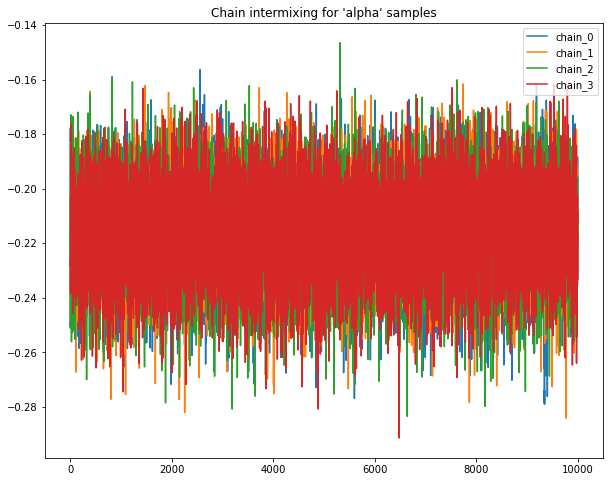

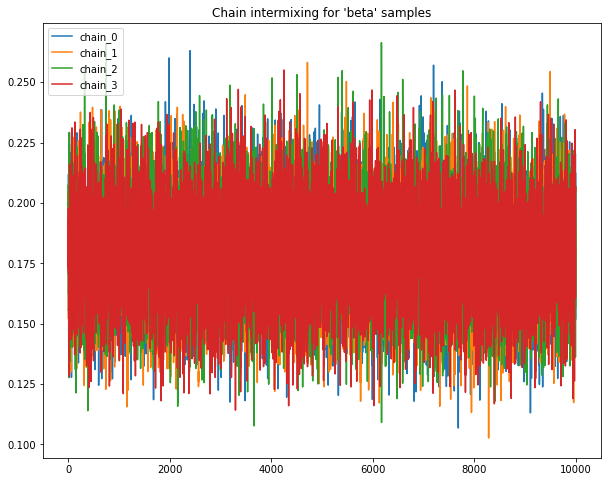

In [14]:
    
base.plot_chains(beta_chain_matrix_df)


#### Auto-correlation plots for sample chains with Normal priors

In [15]:

base.autocorrelation_plots(beta_chain_matrix_df)


RadioButtons(description='Parameters:', options=('alpha', 'beta'), value='alpha')

SelectMultiple(description='Select Chains', index=(1,), options=('chain_0', 'chain_1', 'chain_2', 'chain_3'), …

Output()

For `alpha`, `thining factor` for `chain_0` is 3, `chain_1` is 3, `chain_2` is 3, `chain_3` is 3

for `beta`, `thinin factor` for `chain_0` is 3, `chain_1` is 3, `chain_2` is 3, `chain_3` is 3



In [16]:

thining_dict = {"chain_0": {"alpha":4, "beta":4}, "chain_1": {"alpha":4, "beta":4}, 
                "chain_2": {"alpha":4, "beta":4}, "chain_3": {"alpha":4, "beta":4}}


In [17]:

pruned_hmc_sample_chains = base.prune_hmc_samples(hmc_sample_chains, thining_dict)



-------------------------
Original sample counts for 'chain_0' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_0' parameters: {'alpha': 4, 'beta': 4} 
Post thining sample counts for 'chain_0' parameters: {'alpha': (2500,), 'beta': (2500,)}


-------------------------
Original sample counts for 'chain_1' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_1' parameters: {'alpha': 4, 'beta': 4} 
Post thining sample counts for 'chain_1' parameters: {'alpha': (2500,), 'beta': (2500,)}


-------------------------
Original sample counts for 'chain_2' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_2' parameters: {'alpha': 4, 'beta': 4} 
Post thining sample counts for 'chain_2' parameters: {'alpha': (2500,), 'beta': (2500,)}


-------------------------
Original sample counts for 'chain_3' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_3' parameters: {'alpha': 4, 'beta': 4} 
Pos

#### Gelman-Rubin statistic for Normal priors

In [18]:

grubin_values = base.gelman_rubin_stats(pruned_hmc_sample_chains)



Gelmen-rubin for 'param' alpha all chains is: 0.9997

Gelmen-rubin for 'param' beta all chains is: 0.9997


In [19]:
# Following diagnostic table is for Un-pruned chains from sampler.
base.get_chain_diagnostics(hmc_chain_diagnostics)


acceptance rate divergences  metric_values
parameters chain   metric                                            
beta       chain_0 n_eff            0.9765          []    4191.906250
                   r_hat            0.9765          []       1.000613
           chain_1 n_eff            0.9891          []    4057.659424
                   r_hat            0.9891          []       1.000336
           chain_2 n_eff            0.9621          []    4745.110352
                   r_hat            0.9621          []       0.999936
           chain_3 n_eff            0.9722          []    3728.569092
                   r_hat            0.9722          []       1.000023
alpha      chain_0 n_eff            0.9765          []    4495.870605
                   r_hat            0.9765          []       1.000639
           chain_1 n_eff            0.9891          []    4366.684082
                   r_hat            0.9891          []       1.000021
           chain_2 n_eff            0.9621          []    5142.791504
                   r_hat            0.9621          []       0.999903
           chain_3 n_eff            0.9722          []    4875.547363
                   r_hat            0.9722          []       0.999976

Based on simple multiple line plots, we can see that, in this run, `chain_3` is behaving differently than the remaining chains. It may be due to really a different initialization. Otherwise, all chains seem to mix well. Therefore, we drop `chain_3` from analysis. However, we need to be cautious about dropping, and we should check what is its effect on the actual predictions -- since sometimes, even though parameters can look very different numerically, they may have very little effect on the likelihood. Neverthless, it implies that either something is not right about the chain or the model is operating at the edge.


#### Descriptive summaries

Following outputs the summary of required statistics such as `"mean", "std", "Q(0.25)", "Q(0.50)", "Q(0.75)"`, select names of statistic metric from given list to view values

In [36]:
#chain results Pruned after ACF plots

beta_chain_matrix_df = pd.DataFrame(pruned_hmc_sample_chains)

base.summary(beta_chain_matrix_df)


SelectionSlider(continuous_update=False, description='Slide to', options=('View 1', 'View 2', 'Clear'), value=…

Select any value


Dropdown(options=('mean', 'std', '25%', '50%', '75%', 'ALL'), value='mean')

Output()

We can also report the 5-point Summary Statistics (mean, Q1-Q4, Std, ) as tabular data per chain and save the dataframe

In [21]:
fit_df = pd.DataFrame()
for chain, values in pruned_hmc_sample_chains.items():
    param_df = pd.DataFrame(values)
    param_df["chain"]= chain
    fit_df= pd.concat([fit_df, param_df], axis=0)

# fit_df.to_csv("data/dogs_classification_hmc_samples.csv", index=False)
fit_df.head(3)

alpha      beta    chain
0 -0.182479  0.155647  chain_0
1 -0.246963  0.211808  chain_0
2 -0.212009  0.191411  chain_0

In [22]:

base.save_parameter_chain_dataframe(fit_df, "data/dogs_classification_hmc_samples.csv")


Button(button_style='info', description='Save', icon='save', style=ButtonStyle(), tooltip='save')

Saved at 'data/dogs_classification_hmc_samples.csv'


In [23]:
# Use following to load data once the results from pyro sampling operation are saved offline
load_button= base.build_upload_button()

FileUpload(value={}, accept='.csv', button_style='info', description='Upload')

In [24]:
# Use following to load data once the results from pyro sampling operation are 
# saved offline
if load_button.value:
    fit_df = base.load_parameter_chain_dataframe(load_button)
fit_df.head(3)

alpha      beta    chain
0 -0.182479  0.155647  chain_0
1 -0.246963  0.211808  chain_0
2 -0.212009  0.191411  chain_0

Following outputs the similar summary of required statistics such as `"mean", "std", "Q(0.25)", "Q(0.50)", "Q(0.75)"`, but in a slightly different format, given a list of statistic names

In [25]:

base.summary(fit_df, layout =2)


SelectionSlider(continuous_update=False, description='Slide to', options=('View 1', 'View 2', 'Clear'), value=…

Select any value


Dropdown(options=('mean', 'std', '25%', '50%', '75%', 'ALL'), value='mean')

Output()

Following plots sampled parameters values as Boxplots with `M parameters` side by side on x axis for each of the `N chains`

Pass the list of `M parameters` and list of `N chains`, with `plot_interactive` as `True or False` to choose between _Plotly_ or _Seaborn_

In [26]:
parameters= ["alpha", "beta"]# All parameters for given model
chains= fit_df["chain"].unique()# Number of chains sampled for given model

In [27]:
# Use plot_interactive=False for Normal seaborn plots offline

base.plot_parameters_for_n_chains(fit_df, chains=['chain_0', 'chain_1', 'chain_2', 'chain_3'], parameters=parameters, plot_interactive=True)



Following plots the `joint distribution` of `pair of each parameter` sampled values for all chains


Pyro -- alpha Vs. beta


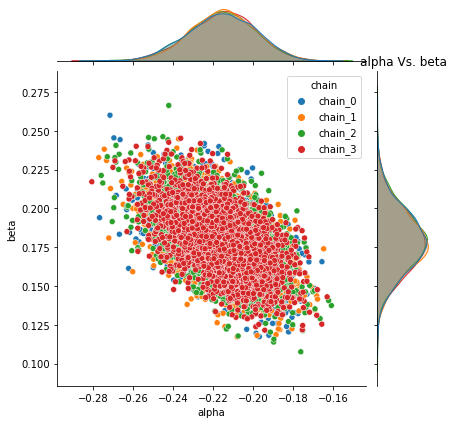

In [28]:

base.plot_joint_distribution(fit_df, parameters)


Following plots the `Pairplot distribution` of each parameter with every other parameter's sampled values

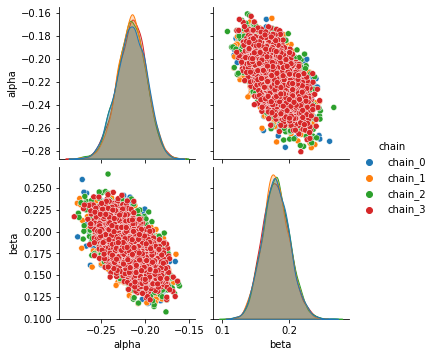

In [29]:
sns.pairplot(data=fit_df, hue= "chain");

Based on all above summaries both visual and descriptive, `chain_2` seemed problematics, and it is very clear that $\alpha, \beta <0$ with almost certainly.

TBD: Converence Statsitics like Gelman-Rubin has to be implemented.

### 6. Sensitivity Analysis

Posterior Predictive Checking (PPE) helps examine the fit of a model to real data, as the parameter drawn for simulating conditions & regions of interests come from the posterior distribution. While PPE incorporates model uncertainly (by averaring over all possible models), we take a simpler route to begin with, which is to, sample the $\alpha, \beta$ pair that is very plausible in the posterior (eg. the poster means), and simulate data from under this particular generative model.

In [30]:
posterior_parameters_pairs_c1= pruned_hmc_sample_chains.get('chain_0')

posterior_parameters_pairs_c1 = list(zip(*list(posterior_parameters_pairs_c1.values())))
print("total posterior samples count in chain:", len(posterior_parameters_pairs_c1), " sample example: ", posterior_parameters_pairs_c1[:2])


total posterior samples count in chain: 2500  sample example:  [(-0.18247911, 0.15564732), (-0.24696335, 0.21180753)]


In [31]:
# simulated_data_given_pair_posterior= simulate_observations_given_param(num_dogs=30, num_trials=24, parameter_pair_list= posterior_parameters_pairs_c1)#, print_logs=1
simulated_data_given_pair_posterior= base.simulate_observations_given_param(init_obs=0, num_dogs=30, num_trials=24, parameter_pair_list= posterior_parameters_pairs_c1)#, print_logs=1
print("Number of datasets/posterior pairs generated: ", simulated_data_given_pair_posterior.shape[0])


Total execution time: 166.57034182548523

Number of datasets/posterior pairs generated:  2500


In [32]:
simulated_data_given_pair_posterior_flattened = np.reshape(simulated_data_given_pair_posterior, (-1, 25))

arr1 = np.mean(dogs_data["Y"], axis=0)# Original
arr2=np.mean(simulated_data_given_pair_flattened, axis=0)# Priors
arr3=np.mean(simulated_data_given_pair_posterior_flattened, axis=0)# Posterior

original_plus_simulated_data_plus_posterior= np.concatenate([arr1.reshape((1, -1)), arr2.reshape((1, -1)), arr3.reshape((1, -1))])

print("respective shapes of original data: %s, data simulated from prior: %s, data simulated from posterior: %s and concatenated arrays: %s"%(arr1.shape, arr2.shape, arr3.shape, original_plus_simulated_data_plus_posterior.shape))

respective shapes of original data: (25,), data simulated from prior: (25,), data simulated from posterior: (25,) and concatenated arrays: (3, 25)


In [34]:

base.plot_original_y(original_plus_simulated_data_plus_posterior, ylabel='Probability of avoidance at trial j [all original & simulated prior data]')

print("\n\nHere 'Dog 1' corresponds to Original data, 'Dog 2' corresponds to data simulated from prior & 'Dog 3' corresponds to data simulated from posterior")





Here 'Dog 1' corresponds to Original data, 'Dog 2' corresponds to data simulated from prior & 'Dog 3' corresponds to data simulated from posterior


### 7. Model Comparison

More often than not, there may be many plausible models that can explain the data. Sometime, the modeling choice is based on _domain knowledge_. Sometime it is out of comptational conveninece. Latter is the case with the choice of priors. One way to consider different models is by eliciting different prior distributions. 

As long as the sampling distribtion is same, one can use Deviance Information Criterion (DIC) to guide model comparison.

#### Deviance Information Criterion

DIC is computed as follows
<Br>

$D(\alpha,\beta) = -2\ \sum_{i=1}^{n} \log P\ (y_{i}\ /\ \alpha,\beta)$

$\log P\ (y_{i}\ /\ \alpha,\beta)$ is the log likehood of shocks/avoidances observed given parameter $\alpha,\beta$, this expression expands as follows:

$$D(\alpha,\beta) = -2\ \sum_{i=1}^{30}[ y_{i}\ (\alpha Xa_{i}\ +\beta\ Xs_{i}) + \ (1-y_{i})\log\ (1\ -\ e^{(\alpha Xa_{i}\ +\beta\ Xs_{i})})]$$

<Br>
Using $D(\alpha,\beta)$ to Compute DIC
<Br>

$\overline D(\alpha,\beta) = \frac{1}{T} \sum_{t=1}^{T} D(\alpha,\beta)$

$\overline \alpha = \frac{1}{T} \sum_{t=1}^{T}\alpha_{t}\\$
$\overline \beta = \frac{1}{T} \sum_{t=1}^{T}\beta_{t}$

$D(\overline\alpha,\overline\beta) = -2\ \sum_{i=1}^{30}[ y_{i}\ (\overline\alpha Xa_{i}\ +\overline\beta\ Xs_{i}) + \ (1-y_{i})\log\ (1\ -\ e^{(\overline\alpha Xa_{i}\ +\overline\beta\ Xs_{i})})]$

<Br>
Therefore finally
<Br>

$DIC\ =\ 2\ \overline D(\alpha,\beta)\ -\ D(\overline\alpha,\overline\beta)$

<Br>
<Br>

<Br>
Following method computes deviance value given parameters `alpha & beta`
<Br>

In [21]:
#launch docstring for calculate_deviance_given_param

#launch docstring for calculate_mean_deviance


<Br>

Following method computes `deviance information criterion` for a given bayesian model & chains of sampled parameters `alpha & beta`

<Br>

In [22]:
#launch docstring for DIC

#launch docstring for compare_DICs_given_model

#### Define alternate model with different priors

The following model is defined in the same manner using Pyro as per the following expression of generative model for this dataset, just with modification of prior distribution to `Uniform` rather than `Normal` as follows:

Instead of considering Normal priors of $\alpha$ and $\beta$, we consider uniform priors, i.e.,
$prior\ \alpha$ ~ $U(-30.79, 30.79)$,  $\beta$ ~ $U(-30.79, 30.79)$

In [35]:
# # Dogs model with uniform prior
#launch docstring for DogsModelUniformPrior

DogsModelUniformPrior= base.DogsModelUniformPrior
DogsModelUniformPrior

<function __main__.DogsModelUniformPrior(x_avoidance, x_shocked, y)>

In [38]:

hmc_sample_chains_uniform_prior, hmc_sample_chains_uniform_diagnostics= base.get_hmc_n_chains(DogsModelUniformPrior, x_avoidance, x_shocked, y, num_chains=4, sample_count= 900)



Sample: 100%|██████████| 11000/11000 [02:00, 91.57it/s, step size=3.36e-02, acc. prob=0.947] 



Total time:  465.27906799316406


#### Sample chains mixing for Uniform priors
Following plots chains of samples for alpha & beta parameters with uniform priors

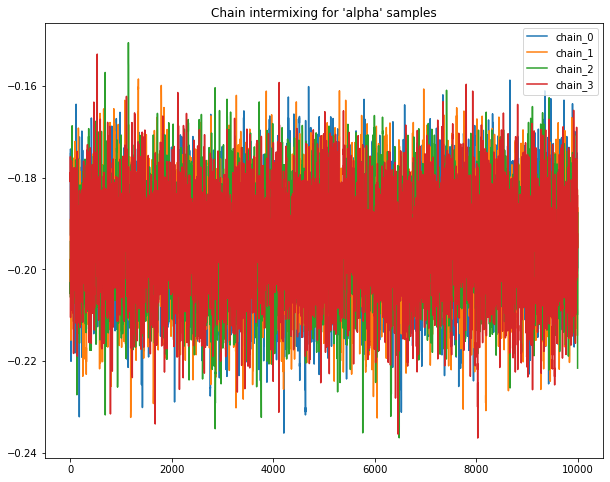

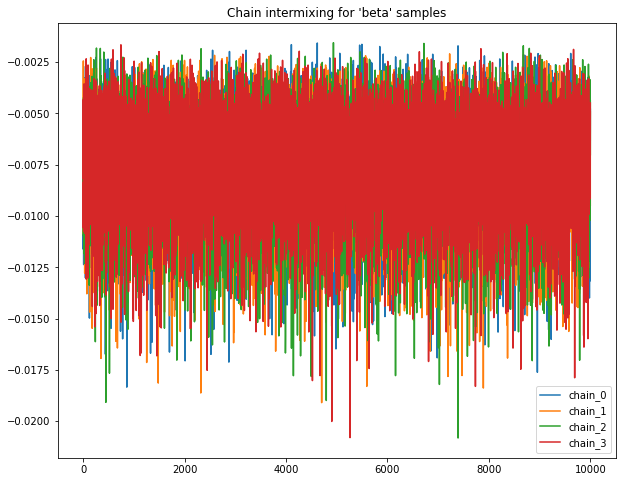

In [39]:
beta_chain_matrix_uniform_df = pd.DataFrame(hmc_sample_chains_uniform_prior)

base.plot_chains(beta_chain_matrix_uniform_df)


#### Auto-correlation plots for sample chains with Uniform priors

In [40]:

base.autocorrelation_plots(beta_chain_matrix_uniform_df)


RadioButtons(description='Parameters:', index=1, options=('alpha', 'beta'), value='beta')

SelectMultiple(description='Select Chains', index=(3,), options=('chain_0', 'chain_1', 'chain_2', 'chain_3'), …

Output()

In [41]:
thining_dict_uniform = {"chain_0": {"alpha":7, "beta":7}, "chain_1": {"alpha":7, "beta":7}, 
                "chain_2": {"alpha":7, "beta":7}, "chain_3": {"alpha":7, "beta":7}}


pruned_hmc_sample_chains_uniform_prior = base.prune_hmc_samples(hmc_sample_chains_uniform_prior, thining_dict_uniform)


-------------------------
Original sample counts for 'chain_0' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_0' parameters: {'alpha': 7, 'beta': 7} 
Post thining sample counts for 'chain_0' parameters: {'alpha': (1429,), 'beta': (1429,)}


-------------------------
Original sample counts for 'chain_1' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_1' parameters: {'alpha': 7, 'beta': 7} 
Post thining sample counts for 'chain_1' parameters: {'alpha': (1429,), 'beta': (1429,)}


-------------------------
Original sample counts for 'chain_2' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_2' parameters: {'alpha': 7, 'beta': 7} 
Post thining sample counts for 'chain_2' parameters: {'alpha': (1429,), 'beta': (1429,)}


-------------------------
Original sample counts for 'chain_3' parameters: {'alpha': (10000,), 'beta': (10000,)}

Thining factors for 'chain_3' parameters: {'alpha': 7, 'beta': 7} 
Pos

#### Gelman-Rubin statistic for Uniform priors

In [42]:

grubin_values_uniform = base.gelman_rubin_stats(pruned_hmc_sample_chains_uniform_prior)



Gelmen-rubin for 'param' alpha all chains is: 0.9993

Gelmen-rubin for 'param' beta all chains is: 0.9996


#### compute & compare `deviance information criterion` for a multiple bayesian models

In [43]:

base.compare_DICs_given_model(x_avoidance, x_shocked, y, Dogs_normal_prior= pruned_hmc_sample_chains, Dogs_uniform_prior= pruned_hmc_sample_chains_uniform_prior)


______________________________

For model : Dogs_normal_prior
. . .DIC for chain_0: 472.935
. . .DIC for chain_1: 472.774
. . .DIC for chain_2: 472.948
. . .DIC for chain_3: 472.849

. .Mean Deviance information criterion for all chains: 472.876

______________________________

For model : Dogs_uniform_prior
. . .DIC for chain_0: 625.299
. . .DIC for chain_1: 625.173
. . .DIC for chain_2: 625.596
. . .DIC for chain_3: 625.659

. .Mean Deviance information criterion for all chains: 625.432



The DIC values are very close, so we don't anticipate substantially different fits. This is largely because, both priors are flat. However, if were to follow the rule book, we had to pick a model with the smallest DIC. In that case, we have to pick `Normal` Priors over `Uniform` Priors.

### 8. Inference & Analysis

Alright, we have a model, and we are reasonable sure about the fit (both numerical and conceptual), but so what? The purpose of model building is to use these models as probing devices. That is, using the models can we answer some questions about the reality that these models have abstracted. 


We choose model with Normal Prior, and pick samples from one particular chain of HMC samples say `chain_3`

In [44]:
for chain, samples in pruned_hmc_sample_chains.items():
    samples= dict(map(lambda param: (param, torch.tensor(samples.get(param))), samples.keys()))# np array to tensors
    print(chain, "Sample count: ", len(samples["alpha"]))

chain_0 Sample count:  2500
chain_1 Sample count:  2500
chain_2 Sample count:  2500
chain_3 Sample count:  2500


Plot density for parameters from `chain_3` to visualise the spread of sample values from that chain

In [45]:
title= "parameter distribution for : %s"%(chain)
fig = ff.create_distplot(list(map(lambda x:x.numpy(), samples.values())), list(samples.keys()))
fig.update_layout(title=title, xaxis_title="parameter values", yaxis_title="density", legend_title="parameters")
fig.show()

print("Alpha Q(0.5) :%s | Beta Q(0.5) :%s"%(torch.quantile(samples["alpha"], 0.5), torch.quantile(samples["beta"], 0.5)))


Alpha Q(0.5) :tensor(-0.2148) | Beta Q(0.5) :tensor(0.1786)


Plot density & contours for both parameters from `chain_3` to visualise the joint distribution & region of interest

In [46]:
#Choosing samples from chain 3
chain_samples_df= fit_df[fit_df["chain"]==chain].copy()# chain is 'chain_3' 

alpha= chain_samples_df["alpha"].tolist()
beta= chain_samples_df["beta"].tolist()
colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]
fig = ff.create_2d_density(alpha, beta, colorscale=colorscale, hist_color='rgb(255, 255, 150)', point_size=4, title= "alpha beta joint density plot")
fig.update_layout( xaxis_title="x (alpha)", yaxis_title="y (beta)")

fig.show()

**Note:** The distribution of alpha values are significantly offset to the left from beta values, by almost 13 times; Thus for any given input observation of avoidances or shocks, the likelihood of getting shocked is more influenced by small measure of avoidance than by getting shocked.

#### Observations:

On observing the joint distribution of $\alpha, \beta$, we note that $\beta > \alpha$  and $\beta$ is closer to zero. 
Here, $\beta$ can be interpreted as _learning ability_, i.e., the ability of a dog to learn from _shock_ experiences. The increase in number of shocks barely raises the probability of non-avoidance (value of 𝜋𝑗) with little amount. Unless the trials & shocks increase considerably large in progression, it doesn't mellow down well and mostly stays around 0.9.

However, it is not the case with $\alpha, \alpha$ is more negative & farthest from 'zero'. It imparts a significant decline in non-avoidance (𝜋𝑗) even for few instances where dog avoids the shock; therefore $\alpha$ can be interpreted as _retention ability_ i.e., the ability to retain the learning from previous shock experiences.

In [47]:
print(chain_samples_df["alpha"].describe(),"\n\n", chain_samples_df["beta"].describe())

count    2500.000000
mean       -0.215691
std         0.016598
min        -0.280845
25%        -0.226861
50%        -0.214832
75%        -0.204219
max        -0.162974
Name: alpha, dtype: float64 

 count    2500.000000
mean        0.179158
std         0.020163
min         0.121527
25%         0.164853
50%         0.178601
75%         0.192828
max         0.245223
Name: beta, dtype: float64


From the contour plot above following region in posterior distribution seems highly plausible for parameters:
1. For alpha, `-0.2 < alpha < -0.19`
2. For beta `-0.0075 < beta < -0.0055`

Let us look at $\frac{\alpha}{\beta}$ as a proxy to see which of the two (_learning ability_ and _retention_ability) are domimant. 

We are using $\frac{\alpha}{\beta}$ as a probing device to answer that question, and similar quantities can be defined. With MCMC samples available, we can get posterior probabilties of any function of the model parameters (here $\alpha, \beta$. Say, we can be interested in the $E(\frac{\alpha}{\beta})$ or $P(\frac{\alpha}{\beta}<1)$.

The latter quantity can be estimate by the Monte Carlo average as follows:
$P(\frac{\alpha}{\beta}>1) = \frac{1}{n}\sum_{t=1}^{n} I(\alpha < \beta)$, i.e, the fraction of times $\alpha < \beta$.

In [48]:
x1 = chain_samples_df["alpha"].to_numpy()
x2 = chain_samples_df["beta"].to_numpy()
p = np.mean(x1<x2)
print(p)

1.0


So, the posterior evident for _retention ability_ outweigting _learning abilty_ is overwhelming.  

### 9. Discussions
.

TBD.

____________________